In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

# Set visualization style
plt.style.use('ggplot')  # Using a standard style that should be available
sns.set()  # Default seaborn style
plt.rcParams['figure.figsize'] = (12, 6)

# Load the NYC Housing Dataset
file_path = 'data\Final_NYC_Housing_Dataset.csv'
df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (83, 14)

First 5 rows:


,DATE,ZHVI,YOY_CHANGE,SALES_VOLUME,INVENTORY,DOM,MORTGAGE,POPULATION,UNEMPLOYMENT_RATE,MEDIAN_INCOME,CPI,MARKET_HEAT_INDEX,GOOGLE_TREND,CONSUMER_SENTIMENT
0,2018-03,652524.0089,7.756677,14047,73707,68,4.4440,NaN,4.3,NaN,249.577,55,67,101.4
1,2018-04,656864.5454,7.471338,14780,80345,65,4.4675,NaN,4.2,NaN,250.227,56,55,98.8
2,2018-05,661945.9429,7.625250,16869,85864,63,4.5860,NaN,4.1,NaN,250.792,55,62,98.0
3,2018-06,665867.5000,7.632281,19562,90067,64,4.5700,NaN,4.0,NaN,251.018,52,63,98.2
4,2018-07,669849.7909,7.815212,19467,91881,66,4.5275,NaN,3.9,NaN,251.214,53,68,97.9


In [2]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found.")

# Convert DATE to datetime format if it's not already
if df['DATE'].dtype != 'datetime64[ns]':
    df['DATE'] = pd.to_datetime(df['DATE'])

# Summary statistics
print("\nSummary Statistics:")
df.describe().T

# Check the time range of the dataset
print(f"\nData time range: {df['DATE'].min()} to {df['DATE'].max()}")
print(f"Total period: {(df['DATE'].max() - df['DATE'].min()).days // 30} months")

Missing values in each column:
POPULATION           77
UNEMPLOYMENT_RATE     1
MEDIAN_INCOME        78
dtype: int64

Summary Statistics:

Data time range: 2018-03-01 00:00:00 to 2025-01-01 00:00:00
Total period: 83 months


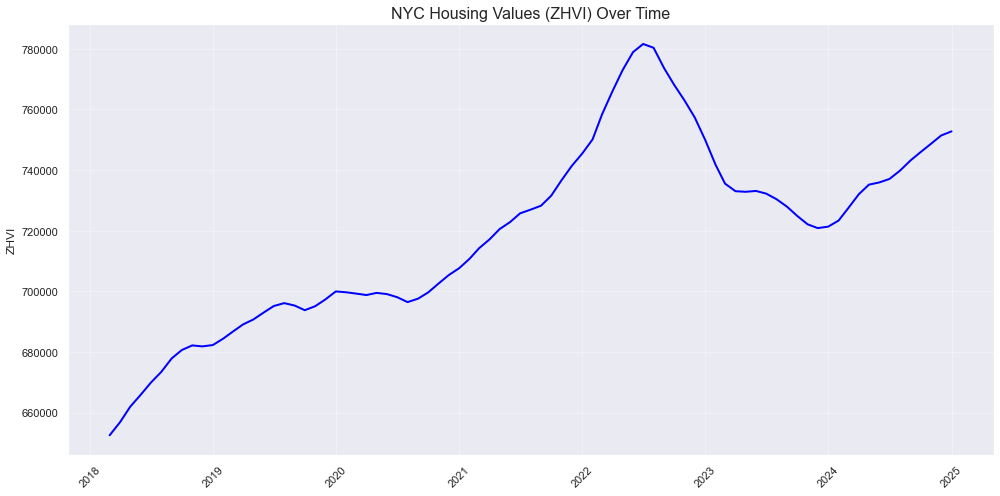

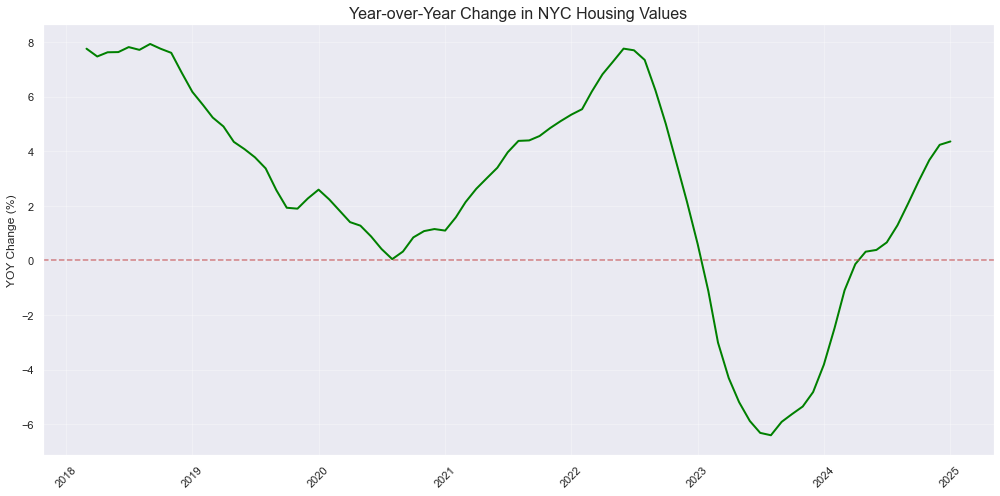

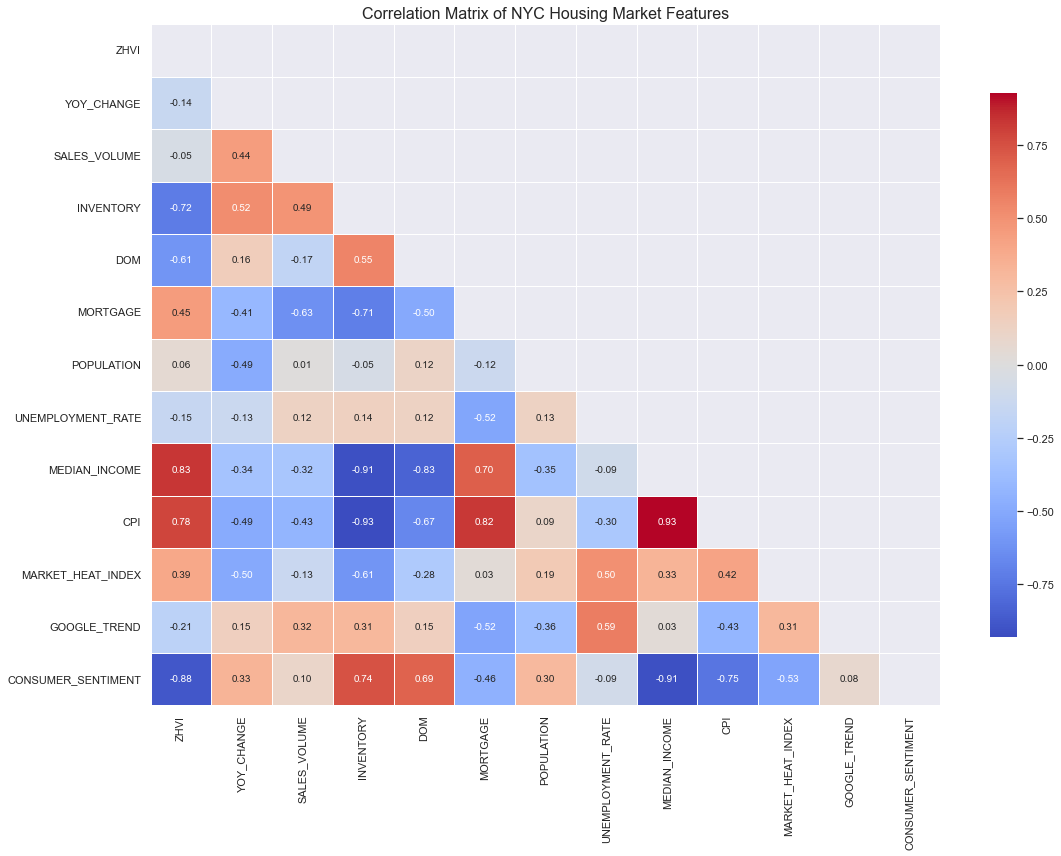

In [3]:
# Set the DATE as index for time series analysis
df_ts = df.copy()
df_ts.set_index('DATE', inplace=True)

# Plot ZHVI (housing values) over time
plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['ZHVI'], color='blue', linewidth=2)
plt.title('NYC Housing Values (ZHVI) Over Time', fontsize=16)
plt.ylabel('ZHVI', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot YOY_CHANGE to see annual growth rate
plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['YOY_CHANGE'], color='green', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.title('Year-over-Year Change in NYC Housing Values', fontsize=16)
plt.ylabel('YOY Change (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap of key variables
plt.figure(figsize=(16, 12))
correlation_matrix = df_ts.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of NYC Housing Market Features', fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Set DATE as index if not already
if 'DATE' in df_processed.columns:
    df_processed.set_index('DATE', inplace=True)

# Handle missing values (if any)
if df_processed.isnull().sum().sum() > 0:
    print("Handling missing values...")
    df_processed = df_processed.interpolate(method='time')
    
    # Check if all missing values are handled
    missing_after = df_processed.isnull().sum().sum()
    print(f"Missing values after interpolation: {missing_after}")

# Group features by category
housing_features = ['ZHVI', 'YOY_CHANGE', 'SALES_VOLUME', 'INVENTORY', 'DOM']
economic_features = ['MORTGAGE', 'POPULATION', 'UNEMPLOYMENT_RATE', 'MEDIAN_INCOME', 'CPI']
sentiment_features = ['MARKET_HEAT_INDEX', 'GOOGLE_TREND', 'CONSUMER_SENTIMENT']

# Scale numerical features
scaler = StandardScaler()
numerical_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df_processed.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

print("Preprocessing completed.")
print(f"Shape of processed dataframe: {df_processed.shape}")
print(f"Shape of scaled dataframe: {df_scaled.shape}")

# Display head of the scaled dataframe
df_scaled.head()

Handling missing values...
Missing values after interpolation: 20
Preprocessing completed.
Shape of processed dataframe: (83, 13)
Shape of scaled dataframe: (83, 13)


,ZHVI,YOY_CHANGE,SALES_VOLUME,INVENTORY,DOM,MORTGAGE,POPULATION,UNEMPLOYMENT_RATE,MEDIAN_INCOME,CPI,MARKET_HEAT_INDEX,GOOGLE_TREND,CONSUMER_SENTIMENT
DATE,,,,,,,,,,,,,
2018-03-01,-2.172370,1.339970,-0.427440,0.533105,-0.164517,-0.233815,NaN,-0.418495,NaN,-1.255217,-1.152892,0.852069,1.612918
2018-04-01,-2.029986,1.267216,-0.234909,0.891110,-0.357747,-0.218817,NaN,-0.456087,NaN,-1.227879,-1.082116,-0.381449,1.433075
2018-05-01,-1.863299,1.306460,0.313793,1.188763,-0.486567,-0.143189,NaN,-0.493679,NaN,-1.204115,-1.152892,0.338103,1.377739
2018-06-01,-1.734659,1.308252,1.021142,1.415442,-0.422157,-0.153401,NaN,-0.531271,NaN,-1.194610,-1.365222,0.440896,1.391573
2018-07-01,-1.604027,1.354895,0.996189,1.513276,-0.293337,-0.180524,NaN,-0.568863,NaN,-1.186366,-1.294446,0.954862,1.370822


In [5]:
def engineer_features(df, key_features):
    """
    Create engineered features for time series analysis
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe with time index
    key_features : list
        List of column names to create features from
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with engineered features
    """
    df_eng = df.copy()
    
    # Create lagged features
    print("Creating lagged features...")
    for feature in key_features:
        for lag in [1, 3, 6, 12]:
            if lag < len(df):
                df_eng[f'{feature}_lag_{lag}'] = df_eng[feature].shift(lag)
    
    # Moving averages
    print("Creating moving averages...")
    for feature in key_features:
        for window in [3, 6, 12]:
            if window < len(df):
                df_eng[f'{feature}_ma_{window}'] = df_eng[feature].rolling(window=window).mean()
    
    # Rate of change
    print("Creating rate of change features...")
    for feature in key_features:
        df_eng[f'{feature}_roc_3'] = df_eng[feature].pct_change(periods=3) * 100
        df_eng[f'{feature}_roc_6'] = df_eng[feature].pct_change(periods=6) * 100
    
    # Create ratio features
    print("Creating ratio features...")
    if all(col in df_eng.columns for col in ['ZHVI', 'MEDIAN_INCOME']):
        df_eng['price_to_income'] = df_eng['ZHVI'] / df_eng['MEDIAN_INCOME']
    
    if all(col in df_eng.columns for col in ['INVENTORY', 'SALES_VOLUME']):
        df_eng['inventory_to_sales'] = df_eng['INVENTORY'] / df_eng['SALES_VOLUME'].replace(0, np.nan)
    
    if all(col in df_eng.columns for col in ['MEDIAN_INCOME', 'ZHVI', 'MORTGAGE']):
        df_eng['affordability'] = df_eng['MEDIAN_INCOME'] / (df_eng['ZHVI'] * df_eng['MORTGAGE'] / 100)
    
    # Momentum indicators
    print("Creating momentum indicators...")
    if 'ZHVI' in df_eng.columns:
        # Relative Strength Index (RSI) - simplified version
        delta = df_eng['ZHVI'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss.replace(0, np.nan)
        df_eng['RSI'] = 100 - (100 / (1 + rs))
    
    # Drop rows with NaN values created by lagging/rolling
    initial_rows = len(df_eng)
    df_eng = df_eng.dropna()
    print(f"Dropped {initial_rows - len(df_eng)} rows with NaN values.")
    
    return df_eng

# Select key features for engineering
key_features_for_eng = ['ZHVI', 'YOY_CHANGE', 'SALES_VOLUME', 'INVENTORY', 
                         'DOM', 'MORTGAGE', 'UNEMPLOYMENT_RATE', 'MARKET_HEAT_INDEX']

# Apply feature engineering
df_engineered = engineer_features(df_processed, key_features_for_eng)

# Display the number of features before and after engineering
print(f"\nNumber of features before engineering: {df_processed.shape[1]}")
print(f"Number of features after engineering: {df_engineered.shape[1]}")

# Display the first few rows of the engineered dataset
df_engineered.head()

Creating lagged features...
Creating moving averages...
Creating rate of change features...
Creating ratio features...
Creating momentum indicators...
Dropped 23 rows with NaN values.

Number of features before engineering: 13
Number of features after engineering: 89


,ZHVI,YOY_CHANGE,SALES_VOLUME,INVENTORY,DOM,MORTGAGE,POPULATION,UNEMPLOYMENT_RATE,MEDIAN_INCOME,CPI,...,MORTGAGE_roc_3,MORTGAGE_roc_6,UNEMPLOYMENT_RATE_roc_3,UNEMPLOYMENT_RATE_roc_6,MARKET_HEAT_INDEX_roc_3,MARKET_HEAT_INDEX_roc_6,price_to_income,inventory_to_sales,affordability,RSI
DATE,,,,,,,,,,,,,,,,,,,,,
2019-04-01,689100.2629,4.907514,14125,84211,92,4.1425,19621.442233,3.8,71063.424658,255.233,...,-7.202061,-14.233954,-5.000000,-5.000000,-1.754386,19.148936,9.696975,5.961841,2.489437,99.125153
2019-05-01,690693.8707,4.342942,16558,91255,86,4.0720,19674.212644,3.7,70801.232877,255.296,...,-6.819222,-16.317304,-5.128205,-7.500000,-13.559322,8.510638,9.755393,5.511233,2.517372,99.161065
2019-06-01,693005.2849,4.075553,17575,95966,81,3.8025,19728.742068,3.7,70530.301370,255.213,...,-10.844080,-18.005391,-5.128205,-7.500000,-13.793103,-3.846154,9.825639,5.460370,2.676517,99.114797
2019-07-01,695156.8146,3.778015,18920,97260,81,3.7650,19781.512479,3.8,70268.109589,255.802,...,-9.112855,-15.658602,0.000000,-5.000000,-5.357143,-7.017544,9.892920,5.140592,2.684791,99.038206
2019-08-01,696112.2362,3.371708,19169,95383,85,3.6160,19836.041904,3.8,69997.178082,256.036,...,-11.198428,-17.254005,2.702703,-2.564103,9.803922,-5.084746,9.944861,4.975899,2.780820,98.945871


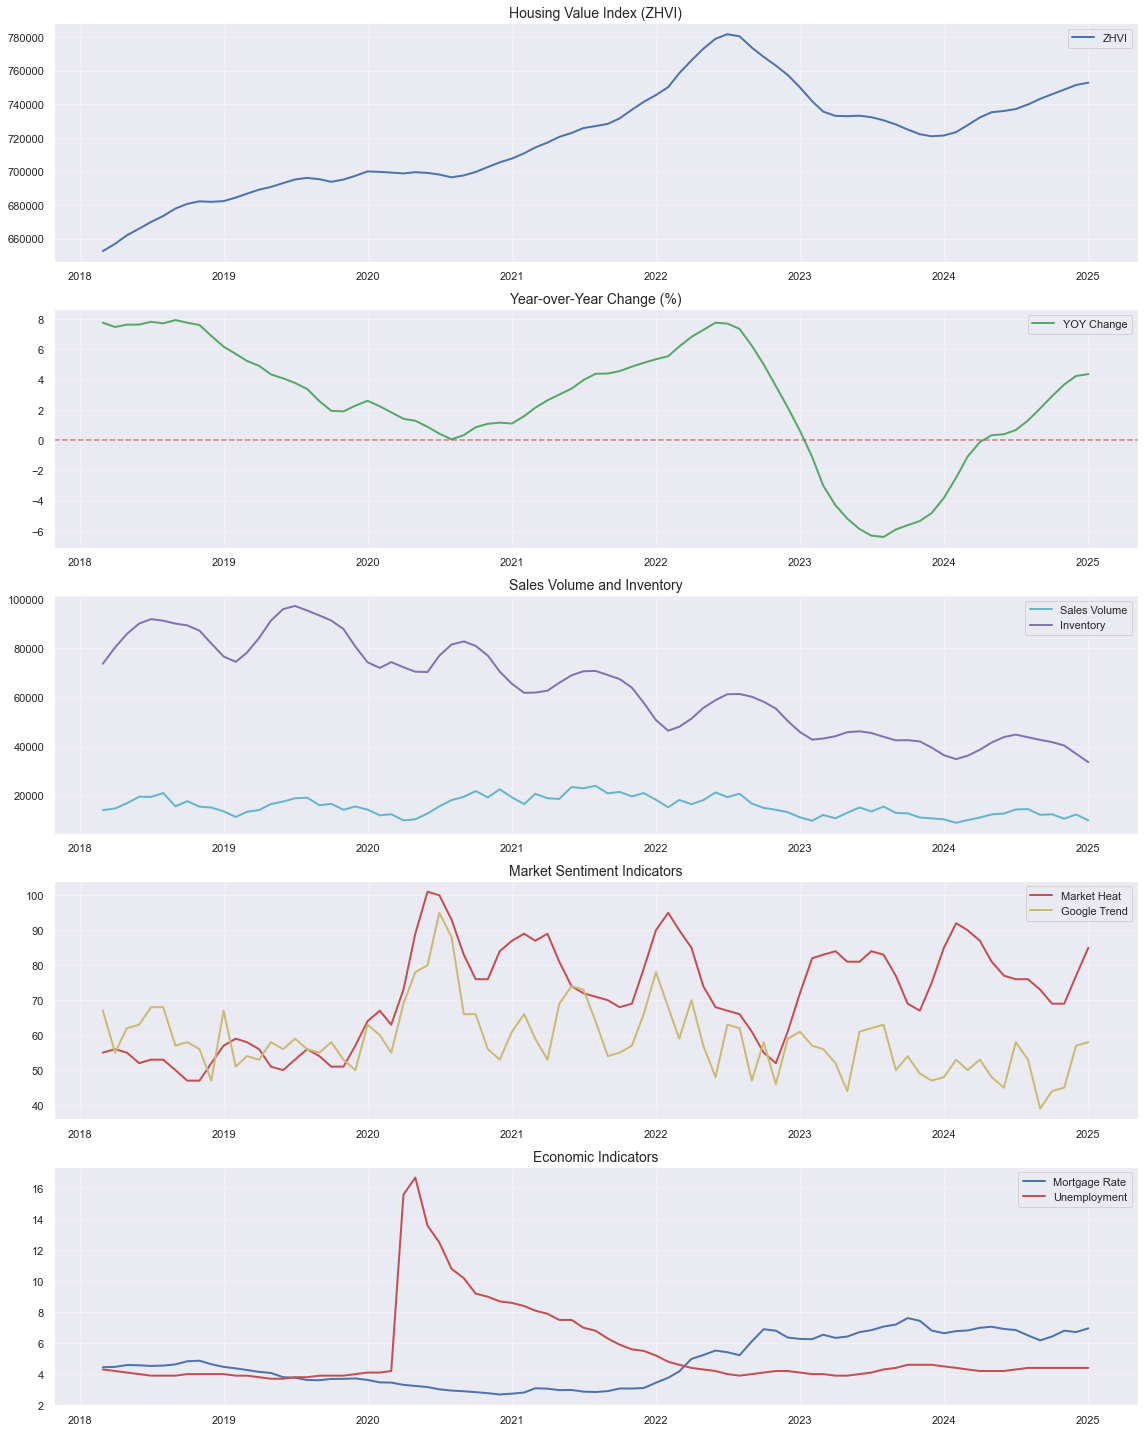

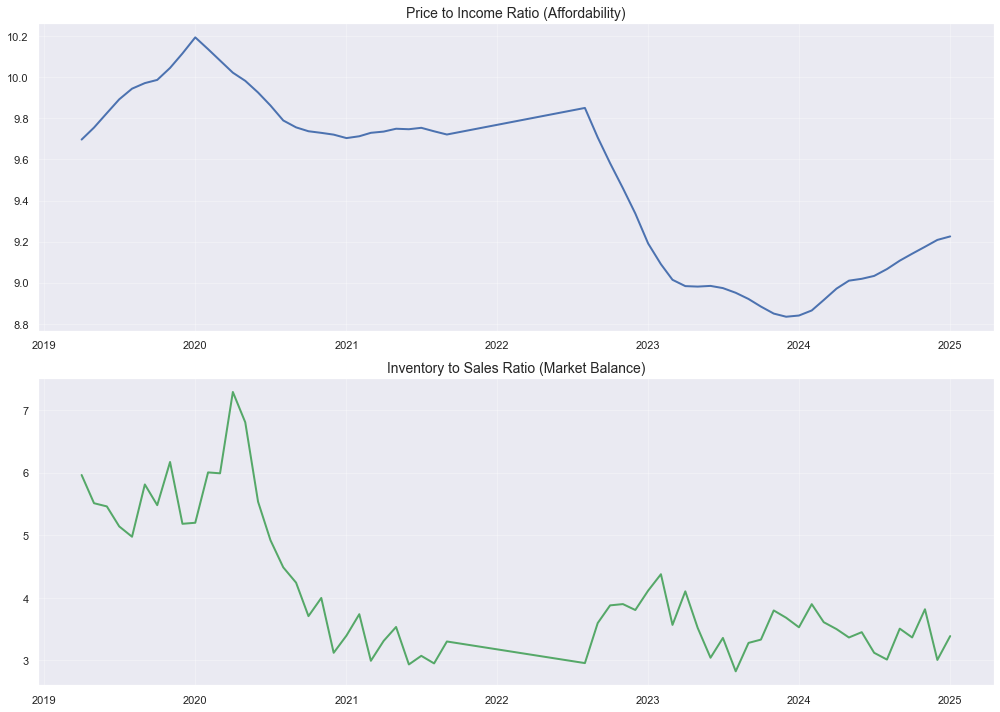

In [6]:
# Plot key features that might help identify different regimes
plt.figure(figsize=(16, 20))

# Housing value and YOY change
plt.subplot(5, 1, 1)
plt.plot(df_processed.index, df_processed['ZHVI'], 'b-', linewidth=2, label='ZHVI')
plt.title('Housing Value Index (ZHVI)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(df_processed.index, df_processed['YOY_CHANGE'], 'g-', linewidth=2, label='YOY Change')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.title('Year-over-Year Change (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Sales and inventory dynamics
plt.subplot(5, 1, 3)
plt.plot(df_processed.index, df_processed['SALES_VOLUME'], 'c-', linewidth=2, label='Sales Volume')
plt.plot(df_processed.index, df_processed['INVENTORY'], 'm-', linewidth=2, label='Inventory')
plt.title('Sales Volume and Inventory', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Market sentiment indicators
plt.subplot(5, 1, 4)
plt.plot(df_processed.index, df_processed['MARKET_HEAT_INDEX'], 'r-', linewidth=2, label='Market Heat')
plt.plot(df_processed.index, df_processed['GOOGLE_TREND'], 'y-', linewidth=2, label='Google Trend')
plt.title('Market Sentiment Indicators', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Economic indicators
plt.subplot(5, 1, 5)
plt.plot(df_processed.index, df_processed['MORTGAGE'], 'b-', linewidth=2, label='Mortgage Rate')
plt.plot(df_processed.index, df_processed['UNEMPLOYMENT_RATE'], 'r-', linewidth=2, label='Unemployment')
plt.title('Economic Indicators', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Check if we have engineered ratio features to plot
if 'price_to_income' in df_engineered.columns and 'inventory_to_sales' in df_engineered.columns:
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(df_engineered.index, df_engineered['price_to_income'], 'b-', linewidth=2)
    plt.title('Price to Income Ratio (Affordability)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(df_engineered.index, df_engineered['inventory_to_sales'], 'g-', linewidth=2)
    plt.title('Inventory to Sales Ratio (Market Balance)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

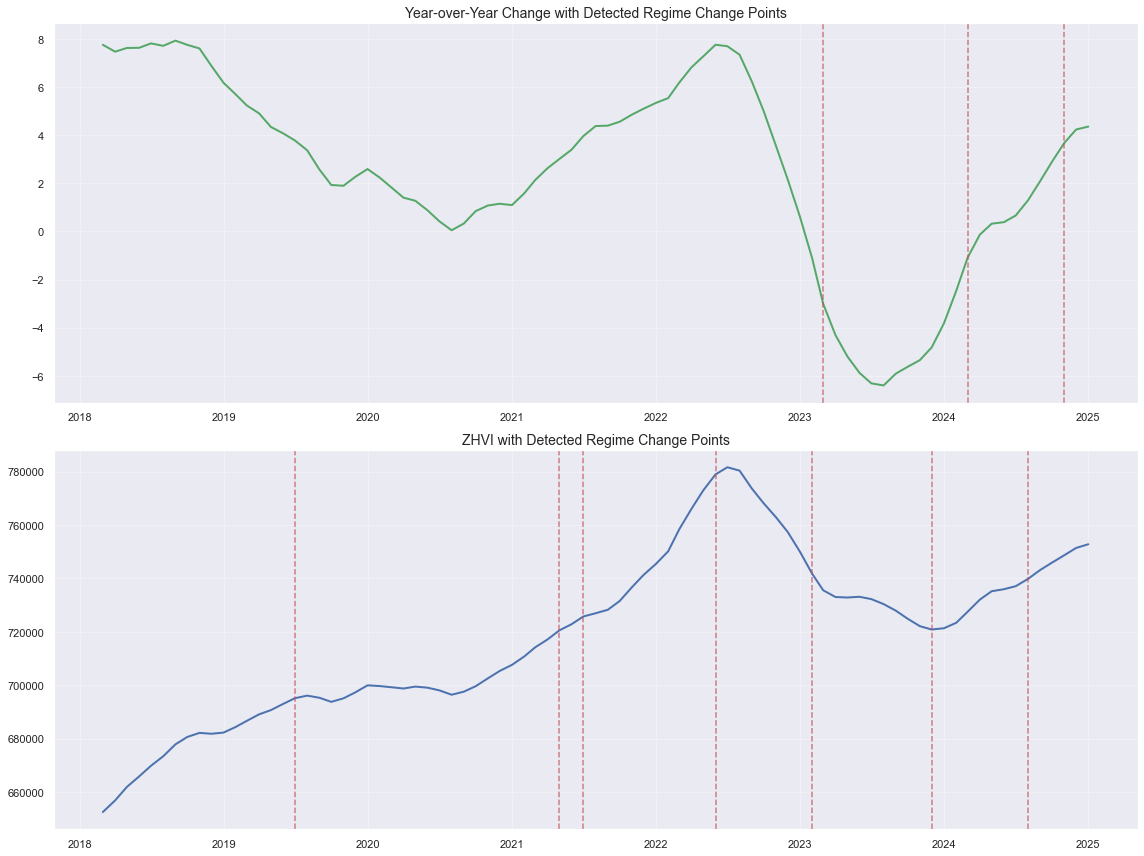

Potential regime change dates based on YOY change:
- 2023-03
- 2024-03
- 2024-11

Potential regime change dates based on ZHVI:
- 2019-07
- 2021-05
- 2021-07
- 2022-06
- 2023-02
- 2023-12
- 2024-08


In [7]:
# Import libraries for change point detection
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def detect_change_points(series, method='derivative', window=3, threshold=1.0):
    """
    Detect significant change points in a time series
    
    Parameters:
    -----------
    series : pandas.Series
        Time series data to analyze
    method : str
        Method to use ('derivative', 'z_score', or 'rolling_std')
    window : int
        Window size for calculations
    threshold : float
        Threshold for change point detection
        
    Returns:
    --------
    list
        Indices of detected change points
    """
    if method == 'derivative':
        # First derivative (rate of change)
        diff = series.diff(window).abs()
        # Normalize
        diff_norm = diff / diff.max()
        # Find peaks
        peaks, _ = find_peaks(diff_norm, height=threshold)
        
    elif method == 'z_score':
        # Calculate rolling z-score
        rolling_mean = series.rolling(window=window).mean()
        rolling_std = series.rolling(window=window).std()
        z_scores = (series - rolling_mean) / rolling_std
        # Find where z-score crosses threshold
        crosses = np.where(np.abs(z_scores) > threshold)[0]
        # Group consecutive indices and take the first of each group
        peaks = [crosses[0]]
        for i in crosses[1:]:
            if i - peaks[-1] > window:
                peaks.append(i)
                
    elif method == 'rolling_std':
        # Calculate rolling standard deviation
        rolling_std = series.rolling(window=window*2).std()
        # Normalize
        std_norm = rolling_std / rolling_std.max()
        # Find peaks
        peaks, _ = find_peaks(std_norm, height=threshold)
    
    return peaks

# Detect change points in ZHVI year-over-year change
yoy_change = df_processed['YOY_CHANGE']
zhvi = df_processed['ZHVI']

# Detect change points using different methods
yoy_peaks = detect_change_points(yoy_change, method='derivative', window=3, threshold=0.4)
zhvi_peaks = detect_change_points(zhvi, method='derivative', window=6, threshold=0.3)

# Plot the results
plt.figure(figsize=(16, 12))

# Plot YOY change with change points
plt.subplot(2, 1, 1)
plt.plot(df_processed.index, yoy_change, 'g-', linewidth=2)
for peak in yoy_peaks:
    plt.axvline(x=df_processed.index[peak], color='r', linestyle='--', alpha=0.7)
plt.title('Year-over-Year Change with Detected Regime Change Points', fontsize=14)
plt.grid(True, alpha=0.3)

# Plot ZHVI with change points
plt.subplot(2, 1, 2)
plt.plot(df_processed.index, zhvi, 'b-', linewidth=2)
for peak in zhvi_peaks:
    plt.axvline(x=df_processed.index[peak], color='r', linestyle='--', alpha=0.7)
plt.title('ZHVI with Detected Regime Change Points', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the detected regime change dates
print("Potential regime change dates based on YOY change:")
for peak in yoy_peaks:
    print(f"- {df_processed.index[peak].strftime('%Y-%m')}")

print("\nPotential regime change dates based on ZHVI:")
for peak in zhvi_peaks:
    print(f"- {df_processed.index[peak].strftime('%Y-%m')}")

Model is not converging.  Current: -105.4215628720165 is not greater than -64.94846683512505. Delta is -40.47309603689145


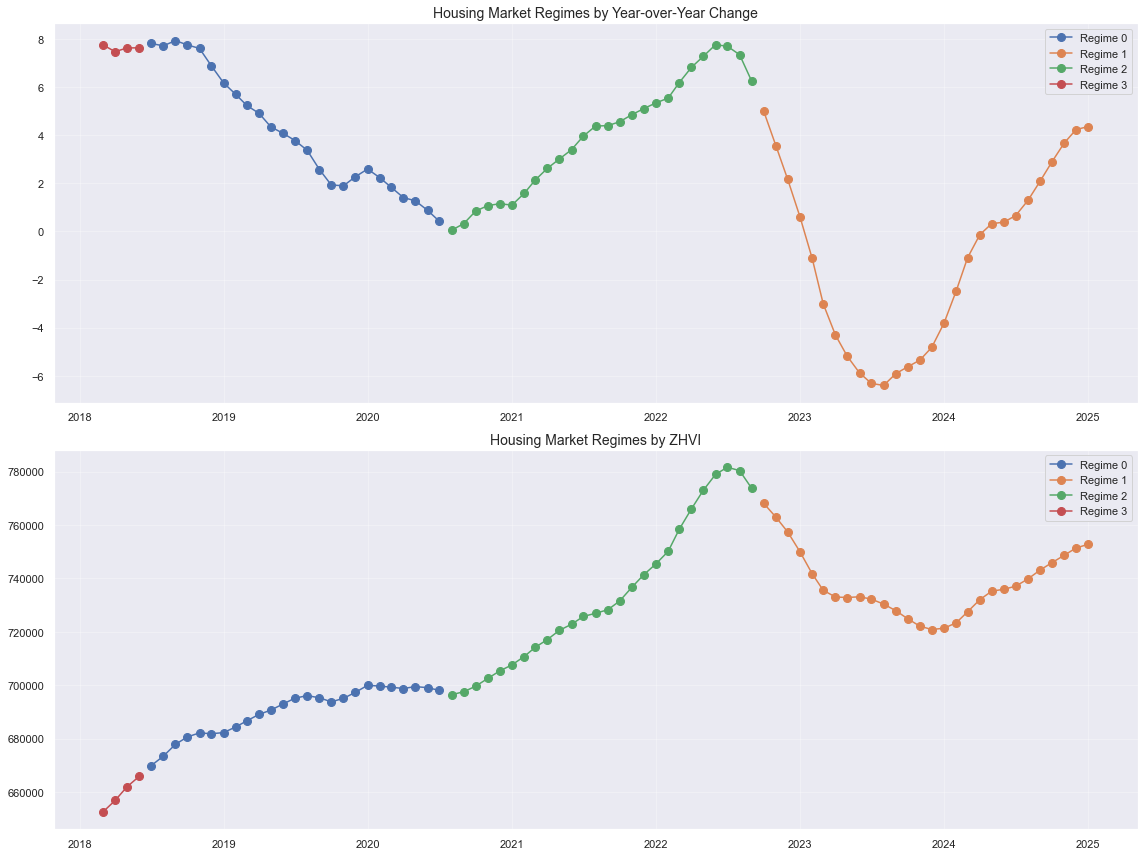

Mean feature values for each detected regime:
Feature  YOY_CHANGE  SALES_VOLUME     INVENTORY        DOM  MORTGAGE
State                                                               
0          4.103538  15162.480000  83564.000000  89.480000  3.939980
1         -1.078665  12245.250000  43011.250000  60.428571  6.759125
2          4.028451  19760.884615  64379.076923  64.115385  3.593750
3          7.621386  16314.500000  82495.750000  65.000000  4.516875

Transition probabilities between regimes:
                 To Regime 0  To Regime 1   To Regime 2   To Regime 3
From Regime 0   9.594596e-01     0.000000  4.054039e-02  2.520570e-49
From Regime 1  4.100815e-235     1.000000  2.405277e-60  0.000000e+00
From Regime 2   8.507584e-40     0.038467  9.615326e-01  0.000000e+00
From Regime 3   2.500001e-01     0.000000  0.000000e+00  7.499999e-01


In [8]:
# Import libraries for HMM implementation
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Select features for the HMM
features_for_hmm = ['YOY_CHANGE', 'SALES_VOLUME', 'INVENTORY', 'DOM', 'MORTGAGE']

# Prepare data for HMM
hmm_data = df_processed[features_for_hmm].copy()

# Handle missing values if any
hmm_data = hmm_data.dropna()

# Scale the data
scaler = StandardScaler()
hmm_data_scaled = scaler.fit_transform(hmm_data)

# Define and fit the HMM with 4 hidden states (market regimes)
model = hmm.GaussianHMM(n_components=4, covariance_type="full", n_iter=100, random_state=42)
model.fit(hmm_data_scaled)

# Predict the hidden states
hidden_states = model.predict(hmm_data_scaled)

# Create a DataFrame with the predicted states
df_states = pd.DataFrame(
    {'date': hmm_data.index, 
     'state': hidden_states,
     'YOY_CHANGE': hmm_data['YOY_CHANGE'],
     'ZHVI': df_processed.loc[hmm_data.index, 'ZHVI']
    }
).set_index('date')

# Plot the results
plt.figure(figsize=(16, 12))

# Plot YOY change with states
plt.subplot(2, 1, 1)
for i in range(model.n_components):
    # Select data points in the current state
    mask = df_states['state'] == i
    plt.plot(df_states.index[mask], 
             df_states['YOY_CHANGE'][mask], 
             'o-', 
             label=f'Regime {i}',
             markersize=8)

plt.title('Housing Market Regimes by Year-over-Year Change', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Plot ZHVI with states
plt.subplot(2, 1, 2)
for i in range(model.n_components):
    # Select data points in the current state
    mask = df_states['state'] == i
    plt.plot(df_states.index[mask], 
             df_states['ZHVI'][mask], 
             'o-', 
             label=f'Regime {i}',
             markersize=8)

plt.title('Housing Market Regimes by ZHVI', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Analyze the mean values for each state to interpret the regimes
state_means = {}
for i in range(model.n_components):
    state_data = hmm_data[hidden_states == i]
    state_means[i] = state_data.mean()

# Convert to DataFrame for display
state_means_df = pd.DataFrame(state_means).T
state_means_df.index.name = 'State'
state_means_df.columns.name = 'Feature'

print("Mean feature values for each detected regime:")
print(state_means_df)

# Calculate transition matrix and convert to percentages
transition_matrix = pd.DataFrame(
    model.transmat_,
    index=[f'From Regime {i}' for i in range(model.n_components)],
    columns=[f'To Regime {i}' for i in range(model.n_components)]
)

print("\nTransition probabilities between regimes:")
print(transition_matrix)

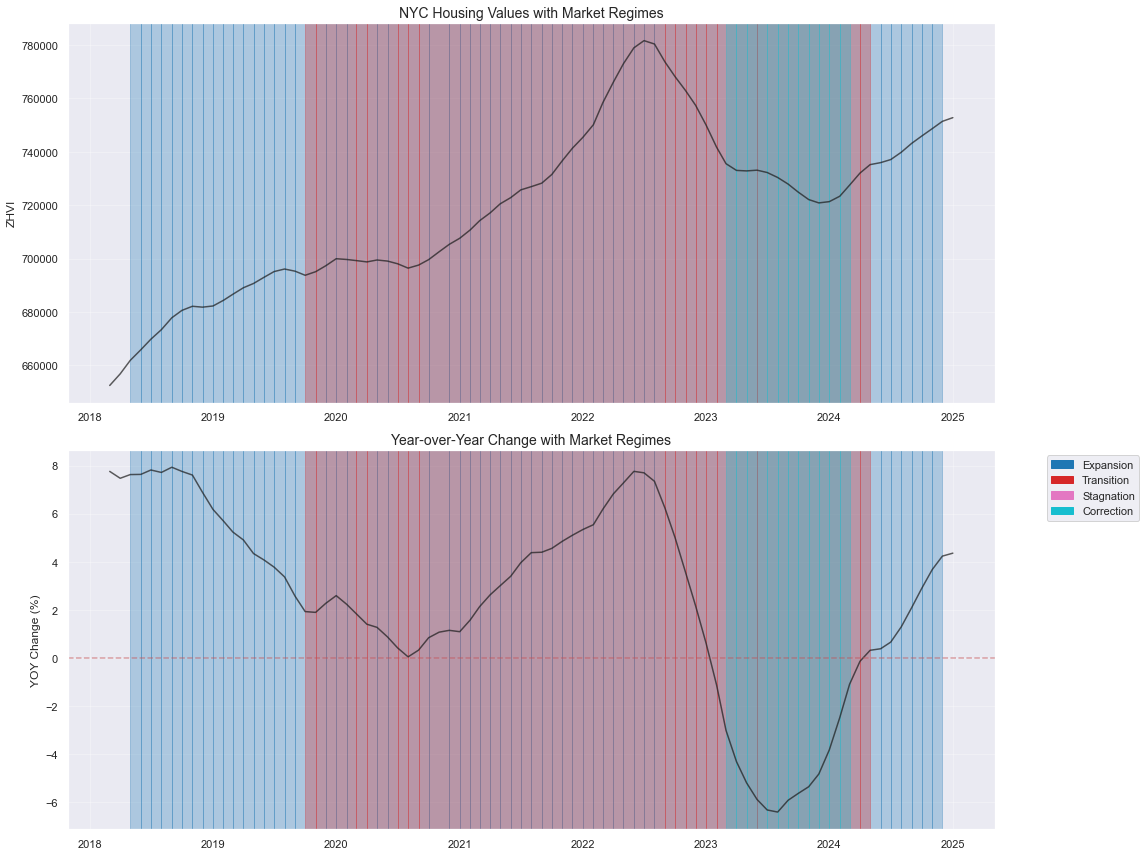

Summary of market regimes in the dataset:
       Regime  Count  Percentage
0   Expansion     51       63.75
1  Transition     16       20.00
2  Correction     12       15.00
3  Stagnation      1        1.25

Current market regime (as of 2025-01): Expansion - Early Recovery

Key metrics for current regime:
- price_change: 4.09
- price_trend: 0.27
- inventory_trend: -8.79
- sales_trend: -1.55
- dom_trend: 8.01
- market_heat: 77.00


In [9]:
def classify_market_regime(data, lookback=3):
    """
    Classify market regime based on recent data
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataframe with market indicators
    lookback : int
        Number of months to look back for analysis
        
    Returns:
    --------
    str
        Market regime classification
    """
    # Get recent data
    recent = data.iloc[-lookback:].copy()
    
    # Key metrics for classification
    price_change = recent['YOY_CHANGE'].mean()
    price_trend = recent['ZHVI'].pct_change().mean() * 100
    inventory_trend = recent['INVENTORY'].pct_change().mean() * 100
    sales_trend = recent['SALES_VOLUME'].pct_change().mean() * 100
    dom_trend = recent['DOM'].pct_change().mean() * 100
    
    if 'MARKET_HEAT_INDEX' in recent.columns:
        market_heat = recent['MARKET_HEAT_INDEX'].mean()
    else:
        market_heat = 50  # default value
    
    # Classification rules based on economic indicators
    if price_change > 5 and sales_trend > 0 and inventory_trend < 0:
        regime = "Expansion"
        phase = "Steady Growth Phase"
    elif price_change > 10 and price_trend > 1.5 and market_heat > 70:
        regime = "Speculative"
        phase = "Bubble Formation"
    elif price_change < 0 and sales_trend < 0:
        regime = "Correction"
        phase = "Price Decline"
    elif abs(price_change) < 2 and abs(sales_trend) < 1:
        regime = "Stagnation"
        phase = "Low Growth Phase"
    else:
        # When conditions are mixed
        if price_change > 0 and price_trend > 0:
            regime = "Expansion"
            phase = "Early Recovery"
        elif price_change < 0 and price_trend > 0:
            regime = "Transition"
            phase = "Recovery Beginning"
        elif price_change > 0 and price_trend < 0:
            regime = "Transition"
            phase = "Growth Slowing"
        else:
            regime = "Correction"
            phase = "Early Correction"
    
    return regime, phase, {
        'price_change': price_change,
        'price_trend': price_trend,
        'inventory_trend': inventory_trend,
        'sales_trend': sales_trend,
        'dom_trend': dom_trend,
        'market_heat': market_heat if 'MARKET_HEAT_INDEX' in recent.columns else None
    }

# Create a function to analyze regimes over time
def analyze_regime_history(df, window=3, step=1):
    """
    Analyze regime changes over time
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with market indicators
    window : int
        Window size for regime classification
    step : int
        Step size for moving window
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe with regime classifications over time
    """
    results = []
    
    for i in range(window, len(df), step):
        subset = df.iloc[i-window:i]
        date = subset.index[-1]
        regime, phase, metrics = classify_market_regime(subset, lookback=window)
        
        results.append({
            'date': date,
            'regime': regime,
            'phase': phase,
            'price_change': metrics['price_change'],
            'price_trend': metrics['price_trend'],
            'inventory_trend': metrics['inventory_trend'],
            'sales_trend': metrics['sales_trend']
        })
    
    return pd.DataFrame(results).set_index('date')

# Apply the regime analysis to the entire dataset
regime_history = analyze_regime_history(df_processed, window=3, step=1)

# Plot the regime history
plt.figure(figsize=(16, 12))

# Create a categorical color map for regimes
regime_categories = regime_history['regime'].unique()
colors = cm.tab10(np.linspace(0, 1, len(regime_categories)))
regime_color_map = dict(zip(regime_categories, colors))

# Plot ZHVI
ax1 = plt.subplot(2, 1, 1)
plt.plot(df_processed.index, df_processed['ZHVI'], 'k-', linewidth=1.5, alpha=0.7)

# Color the background based on regimes
for regime in regime_categories:
    regime_periods = regime_history[regime_history['regime'] == regime]
    for i in range(len(regime_periods)):
        if i < len(regime_periods) - 1:
            start_date = regime_periods.index[i]
            end_date = regime_periods.index[i+1]
            plt.axvspan(start_date, end_date, alpha=0.3, color=regime_color_map[regime])

plt.title('NYC Housing Values with Market Regimes', fontsize=14)
plt.ylabel('ZHVI', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot YOY change
ax2 = plt.subplot(2, 1, 2)
plt.plot(df_processed.index, df_processed['YOY_CHANGE'], 'k-', linewidth=1.5, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Color the background based on regimes
for regime in regime_categories:
    regime_periods = regime_history[regime_history['regime'] == regime]
    for i in range(len(regime_periods)):
        if i < len(regime_periods) - 1:
            start_date = regime_periods.index[i]
            end_date = regime_periods.index[i+1]
            plt.axvspan(start_date, end_date, alpha=0.3, color=regime_color_map[regime])

plt.title('Year-over-Year Change with Market Regimes', fontsize=14)
plt.ylabel('YOY Change (%)', fontsize=12)
plt.grid(True, alpha=0.3)

# Create a legend for regimes
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=regime_color_map[regime], label=regime) for regime in regime_categories]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Summarize regime history
regime_summary = regime_history['regime'].value_counts().reset_index()
regime_summary.columns = ['Regime', 'Count']
regime_summary['Percentage'] = regime_summary['Count'] / regime_summary['Count'].sum() * 100

print("Summary of market regimes in the dataset:")
print(regime_summary)

# Current regime
current_regime, current_phase, current_metrics = classify_market_regime(df_processed, lookback=3)
print(f"\nCurrent market regime (as of {df_processed.index[-1].strftime('%Y-%m')}): {current_regime} - {current_phase}")
print("\nKey metrics for current regime:")
for key, value in current_metrics.items():
    if value is not None:
        print(f"- {key}: {value:.2f}")

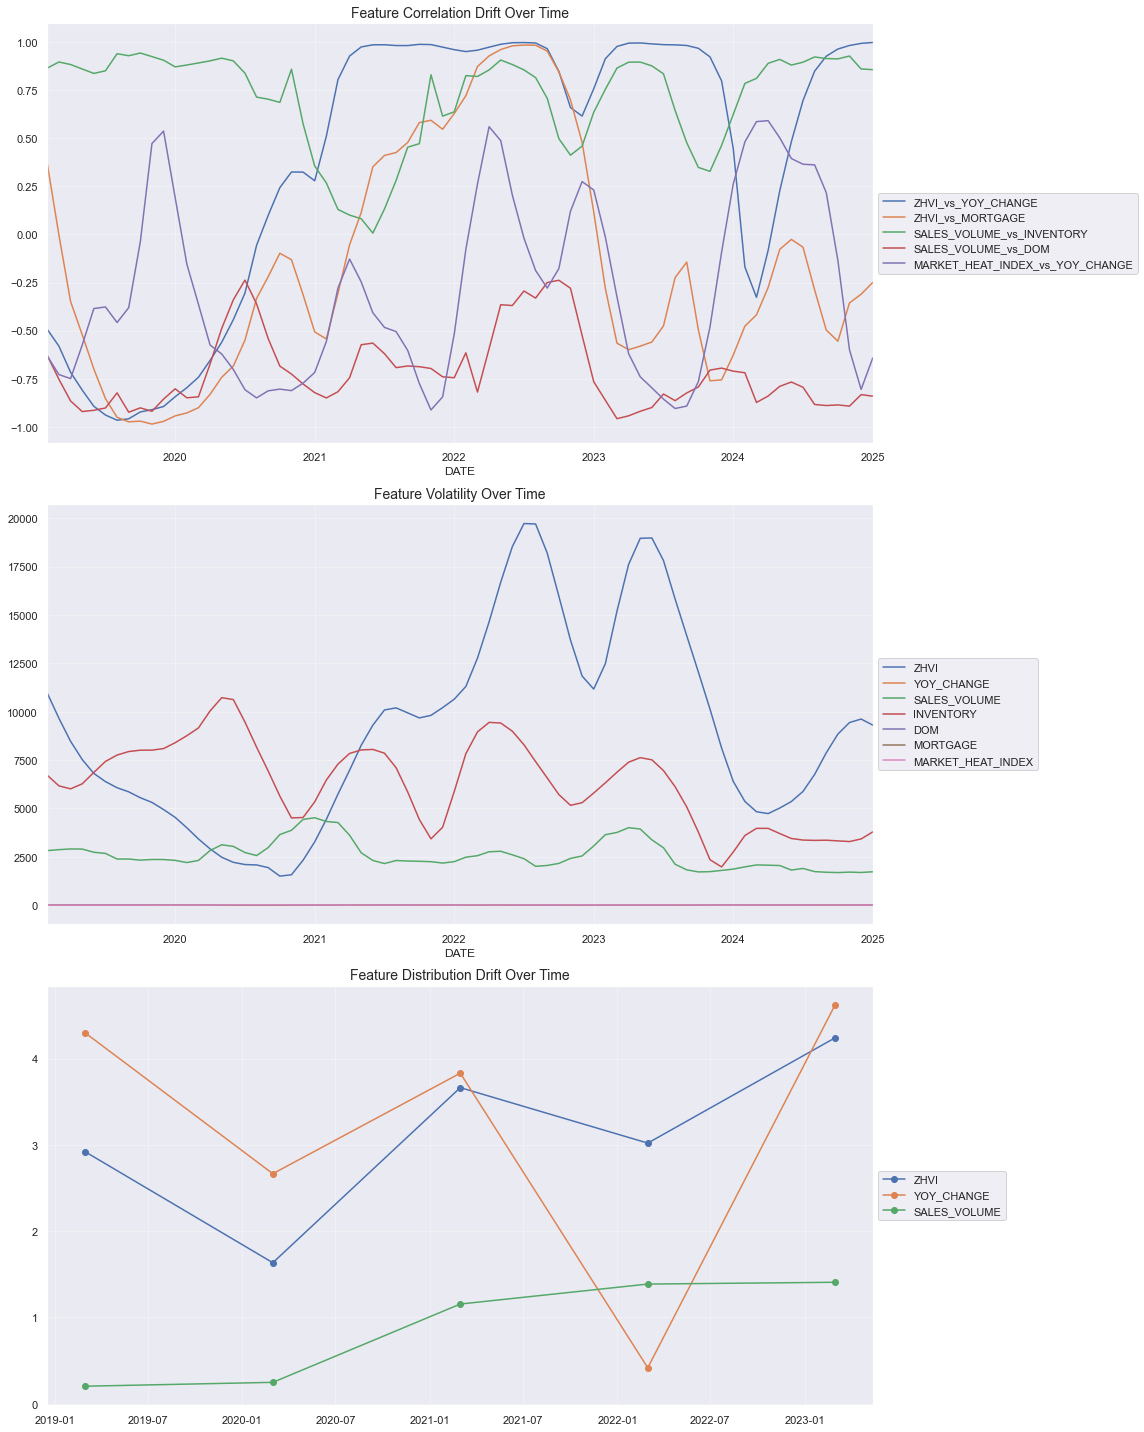

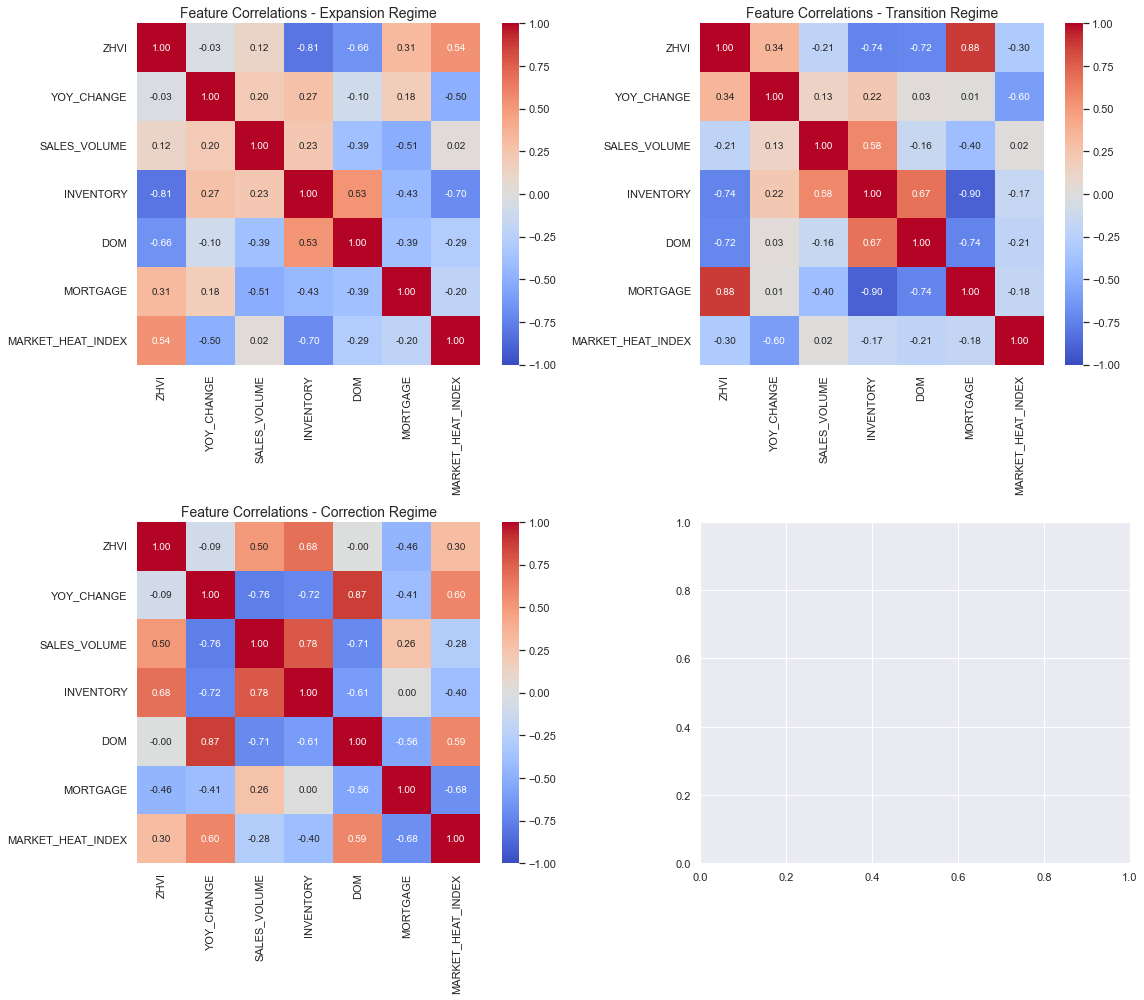

In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

# Define a function to analyze feature drift over time
def analyze_feature_drift(df, window_size=12):
    """
    Analyze how feature relationships change over time
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series data with features
    window_size : int
        Rolling window size for analysis
        
    Returns:
    --------
    dict
        Dictionary containing drift analysis results
    """
    # Select key features for analysis
    key_features = ['ZHVI', 'YOY_CHANGE', 'SALES_VOLUME', 'INVENTORY', 
                   'DOM', 'MORTGAGE', 'MARKET_HEAT_INDEX']
    
    # Create a subset of data with key features
    df_subset = df[key_features].copy()
    
    # Calculate rolling correlations
    correlations = {}
    feature_pairs = [
        ('ZHVI', 'YOY_CHANGE'),
        ('ZHVI', 'MORTGAGE'),
        ('SALES_VOLUME', 'INVENTORY'),
        ('SALES_VOLUME', 'DOM'),
        ('MARKET_HEAT_INDEX', 'YOY_CHANGE')
    ]
    
    for pair in feature_pairs:
        feat1, feat2 = pair
        corr_name = f"{feat1}_vs_{feat2}"
        correlations[corr_name] = df_subset[feat1].rolling(window=window_size).corr(df_subset[feat2])
    
    # Convert rolling correlations to DataFrame
    corr_df = pd.DataFrame(correlations, index=df_subset.index)
    
    # Calculate feature volatility (rolling standard deviation)
    volatility = {}
    for feature in key_features:
        volatility[feature] = df_subset[feature].rolling(window=window_size).std()
    
    # Convert volatility to DataFrame
    vol_df = pd.DataFrame(volatility, index=df_subset.index)
    
    # Calculate feature drift (change in feature distributions)
    drift = {}
    for feature in key_features:
        # Calculate distance between consecutive windows
        drift[feature] = []
        for i in range(window_size, len(df_subset)-window_size, window_size):
            window1 = df_subset[feature].iloc[i-window_size:i]
            window2 = df_subset[feature].iloc[i:i+window_size]
            
            # Calculate distribution distance (simple metric: difference in means normalized by std)
            mean_diff = abs(window1.mean() - window2.mean())
            std_avg = (window1.std() + window2.std()) / 2
            if std_avg > 0:
                dist = mean_diff / std_avg
            else:
                dist = 0
            
            drift[feature].append((df_subset.index[i], dist))
    
    return {
        'correlations': corr_df,
        'volatility': vol_df,
        'drift': drift
    }

# Run the feature drift analysis
drift_results = analyze_feature_drift(df_processed, window_size=12)

# Plot the results
plt.figure(figsize=(16, 20))

# Plot correlation drift
plt.subplot(3, 1, 1)
drift_results['correlations'].dropna().plot(ax=plt.gca())
plt.title('Feature Correlation Drift Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot feature volatility
plt.subplot(3, 1, 2)
drift_results['volatility'].dropna().plot(ax=plt.gca())
plt.title('Feature Volatility Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot feature drift for YOY_CHANGE and ZHVI
plt.subplot(3, 1, 3)
for feature in ['ZHVI', 'YOY_CHANGE', 'SALES_VOLUME']:
    if drift_results['drift'][feature]:
        dates, values = zip(*drift_results['drift'][feature])
        plt.plot(dates, values, 'o-', label=feature)
plt.title('Feature Distribution Drift Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Analyze correlations by regime
# Merge regime history with features
if 'regime_history' in globals() and len(regime_history) > 0:
    # Make sure dates align
    common_dates = sorted(set(regime_history.index) & set(df_processed.index))
    
    # Create a new dataframe with features and regime
    regime_features = pd.DataFrame(index=common_dates)
    regime_features['regime'] = regime_history.loc[common_dates, 'regime']
    
    for feature in ['ZHVI', 'YOY_CHANGE', 'SALES_VOLUME', 'INVENTORY', 'DOM', 'MORTGAGE', 'MARKET_HEAT_INDEX']:
        if feature in df_processed.columns:
            regime_features[feature] = df_processed.loc[common_dates, feature]
    
    # Calculate correlations by regime
    regime_corr = {}
    for regime in regime_features['regime'].unique():
        regime_data = regime_features[regime_features['regime'] == regime]
        if len(regime_data) > 5:  # Need enough data points for correlation
            regime_corr[regime] = regime_data.drop('regime', axis=1).corr()
    
    # Plot correlation matrices for each regime
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    
    for i, (regime, corr_matrix) in enumerate(regime_corr.items()):
        if i < 4:
            sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                       ax=axes[i], vmin=-1, vmax=1)
            axes[i].set_title(f'Feature Correlations - {regime} Regime', fontsize=14)
    
    plt.tight_layout()
    plt.show()

Epoch [10/100], Loss: 0.9821
Epoch [20/100], Loss: 0.8702
Epoch [30/100], Loss: 0.9230
Epoch [40/100], Loss: 0.6603
Epoch [50/100], Loss: 0.5729
Epoch [60/100], Loss: 0.4724
Epoch [70/100], Loss: 0.4099
Epoch [80/100], Loss: 0.4163
Epoch [90/100], Loss: 0.4443
Epoch [100/100], Loss: 0.4513


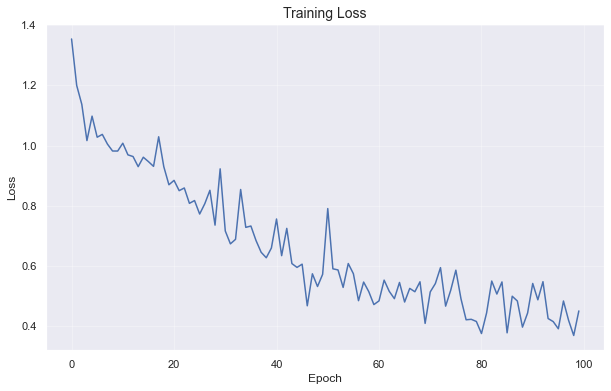

Validation Accuracy: 0.3571


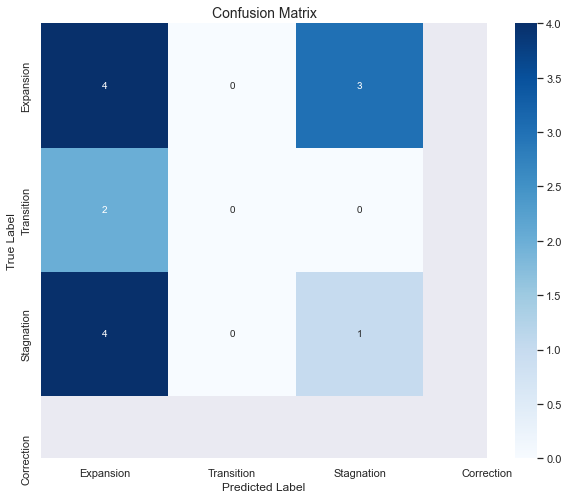

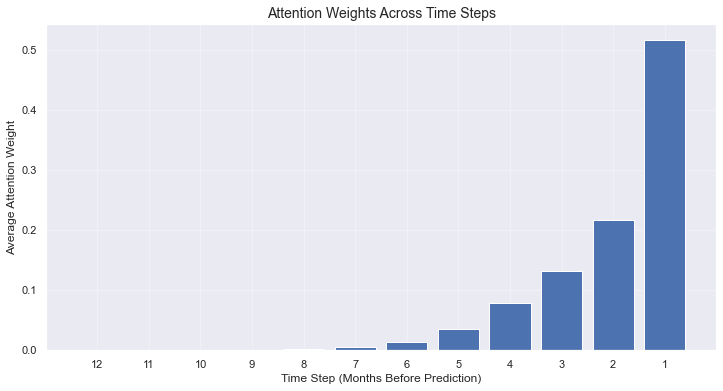

In [11]:
# Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the LSTM model with attention mechanism
class LSTMAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: [batch_size, seq_len, hidden_size]
        
        # Calculate attention weights
        attn_weights = self.attention(lstm_out)
        # attn_weights shape: [batch_size, seq_len, 1]
        
        # Apply softmax to get normalized weights
        attn_weights = torch.softmax(attn_weights, dim=1)
        
        # Apply attention weights to LSTM output
        context = torch.sum(attn_weights * lstm_out, dim=1)
        # context shape: [batch_size, hidden_size]
        
        # Final prediction
        output = self.fc(context)
        # output shape: [batch_size, output_size]
        
        return output, attn_weights

# Function to prepare data for the early warning system
def prepare_early_warning_data(df, feature_cols, target_col, look_back=12, future_window=3):
    """
    Prepare time series data for early warning system
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with features and target
    feature_cols : list
        List of feature column names
    target_col : str
        Name of the target column
    look_back : int
        Number of past time steps to use as input
    future_window : int
        Number of time steps ahead to predict
        
    Returns:
    --------
    tuple
        X, y data for training
    """
    X, y = [], []
    
    # Loop through the data to create sequences
    for i in range(len(df) - look_back - future_window + 1):
        # Extract the sequence of features
        features = df[feature_cols].iloc[i:i+look_back].values
        
        # Get the target value (future regime)
        target = df[target_col].iloc[i+look_back+future_window-1]
        
        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y)

# Function to train the early warning model
def train_early_warning_model(X_train, y_train, input_size, hidden_size=64, 
                             num_layers=2, output_size=4, learning_rate=0.001, 
                             epochs=100, batch_size=16):
    """
    Train the early warning LSTM model
    
    Parameters:
    -----------
    X_train, y_train : numpy arrays
        Training data
    input_size : int
        Number of input features
    hidden_size, num_layers, output_size : int
        Model hyperparameters
    learning_rate, epochs, batch_size : float, int
        Training hyperparameters
        
    Returns:
    --------
    model : LSTMAttention
        Trained model
    history : dict
        Training history
    """
    # Convert data to PyTorch tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.LongTensor(y_train)
    
    # Create dataset and dataloader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize the model
    model = LSTMAttention(input_size, hidden_size, num_layers, output_size)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training history
    history = {'loss': []}
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Record average loss for the epoch
        avg_loss = epoch_loss / len(dataloader)
        history['loss'].append(avg_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    return model, history

# Execute if we have regime data
if 'regime_history' in globals() and len(regime_history) > 0:
    # Create a dataset with features and regimes
    # Map regimes to numerical labels
    regime_mapping = {regime: i for i, regime in enumerate(regime_history['regime'].unique())}
    regime_history['regime_label'] = regime_history['regime'].map(regime_mapping)
    
    # Merge with features
    early_warning_data = df_processed.copy()
    
    # Align dates and add regime labels
    common_dates = sorted(set(regime_history.index) & set(early_warning_data.index))
    early_warning_data = early_warning_data.loc[common_dates]
    early_warning_data['regime_label'] = regime_history.loc[common_dates, 'regime_label']
    
    # Select features for early warning
    feature_cols = ['YOY_CHANGE', 'SALES_VOLUME', 'INVENTORY', 'DOM', 
                   'MORTGAGE', 'MARKET_HEAT_INDEX']
    
    # Check if we have enough data
    if len(early_warning_data) > 30:  # Need sufficient data for meaningful analysis
        # Prepare the data with a 12-month lookback to predict 3 months ahead
        X, y = prepare_early_warning_data(
            early_warning_data, feature_cols, 'regime_label', 
            look_back=12, future_window=3
        )
        
        # Split into training and validation sets (80/20)
        split_idx = int(0.8 * len(X))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]
        
        # Train the model
        input_size = len(feature_cols)
        output_size = len(regime_mapping)
        
        model, history = train_early_warning_model(
            X_train, y_train, input_size, 
            hidden_size=64, num_layers=2, output_size=output_size,
            learning_rate=0.001, epochs=100, batch_size=8
        )
        
        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(history['loss'])
        plt.title('Training Loss', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val)
            y_val_tensor = torch.LongTensor(y_val)
            
            val_outputs, attention_weights = model(X_val_tensor)
            _, predicted = torch.max(val_outputs.data, 1)
            
            accuracy = accuracy_score(y_val, predicted.numpy())
            print(f"Validation Accuracy: {accuracy:.4f}")
            
            # Confusion matrix
            cm = confusion_matrix(y_val, predicted.numpy())
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=list(regime_mapping.keys()),
                       yticklabels=list(regime_mapping.keys()))
            plt.xlabel('Predicted Label', fontsize=12)
            plt.ylabel('True Label', fontsize=12)
            plt.title('Confusion Matrix', fontsize=14)
            plt.show()
            
            # Show feature importance from attention weights
            attention = attention_weights.squeeze().numpy().mean(axis=0)
            
            plt.figure(figsize=(12, 6))
            plt.bar(range(12), attention)
            plt.title('Attention Weights Across Time Steps', fontsize=14)
            plt.xlabel('Time Step (Months Before Prediction)', fontsize=12)
            plt.ylabel('Average Attention Weight', fontsize=12)
            plt.xticks(range(12), range(12, 0, -1))
            plt.grid(True, alpha=0.3)
            plt.show()

Available regimes: ['Expansion', 'Transition', 'Stagnation', 'Correction']


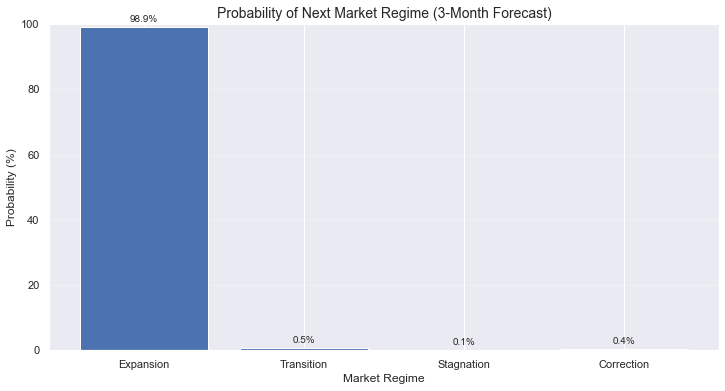

Predicted next market regime: Expansion
Confidence: 98.9%

Investment Recommendations:
- Buy: Market is expected to continue growing
- Asset allocation: Favor real estate and growth stocks
- Mortgage strategy: Consider locking in longer-term fixed rates


In [14]:
# Create a function to predict future regime shifts
def predict_regime_shifts(model, current_data, feature_cols, regime_mapping, num_steps=12):
    """
    Predict probability of regime shifts for future periods
    
    Parameters:
    -----------
    model : LSTMAttention
        Trained early warning model
    current_data : pandas.DataFrame
        Current market data
    feature_cols : list
        List of feature column names
    regime_mapping : dict
        Mapping from regime indices to regime names
    num_steps : int
        Number of future steps to predict
        
    Returns:
    --------
    dict
        Prediction results
    """
    # Extract most recent data for lookback window
    recent_data = current_data[feature_cols].iloc[-12:].values
    
    # Convert to tensor
    input_tensor = torch.FloatTensor(recent_data).unsqueeze(0)
    
    # Model prediction
    model.eval()
    with torch.no_grad():
        output, attention = model(input_tensor)
        probabilities = torch.softmax(output, dim=1).numpy()[0]
        
    # Get the predicted regime
    predicted_idx = np.argmax(probabilities)
    
    # Create inverse mapping from indices to regime names
    inverse_regime_mapping = {i: regime for regime, i in regime_mapping.items()}
    predicted_regime = inverse_regime_mapping[predicted_idx]
    
    return {
        'predicted_regime': predicted_regime,
        'probabilities': {inverse_regime_mapping[i]: prob for i, prob in enumerate(probabilities)},
        'attention_weights': attention.squeeze().numpy()
    }

# Save the regime mapping if it exists for later use
if 'regime_history' in globals() and len(regime_history) > 0:
    # Store the regime mapping for later use
    global_regime_mapping = {regime: i for i, regime in enumerate(regime_history['regime'].unique())}
    print(f"Available regimes: {list(global_regime_mapping.keys())}")

# Plot the forecast with confidence intervals
if all(var in globals() for var in ['model', 'early_warning_data', 'feature_cols', 'global_regime_mapping']):
    try:
        # Generate forecast
        forecast_result = predict_regime_shifts(
            model, 
            early_warning_data, 
            feature_cols, 
            global_regime_mapping
        )
        
        # Prepare visualization
        regime_names = list(global_regime_mapping.keys())
        probabilities = [forecast_result['probabilities'][regime] * 100 for regime in regime_names]
        
        # Plot probabilities
        plt.figure(figsize=(12, 6))
        bars = plt.bar(regime_names, probabilities)
        
        # Add labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 1,
                    f'{height:.1f}%', ha='center', va='bottom')
        
        plt.title('Probability of Next Market Regime (3-Month Forecast)', fontsize=14)
        plt.xlabel('Market Regime', fontsize=12)
        plt.ylabel('Probability (%)', fontsize=12)
        plt.ylim(0, 100)
        plt.grid(True, alpha=0.3, axis='y')
        plt.show()
        
        # Generate decision support based on predicted regime
        print(f"Predicted next market regime: {forecast_result['predicted_regime']}")
        print(f"Confidence: {forecast_result['probabilities'][forecast_result['predicted_regime']]*100:.1f}%")
        
        # Get current regime
        if 'current_regime' in globals():
            current_reg = current_regime
        else:
            # Use the most recent regime from history
            current_reg = regime_history['regime'].iloc[-1]
        
        # Investment recommendations based on predicted regime
        print("\nInvestment Recommendations:")
        if forecast_result['predicted_regime'] == 'Expansion':
            print("- Buy: Market is expected to continue growing")
            print("- Asset allocation: Favor real estate and growth stocks")
            print("- Mortgage strategy: Consider locking in longer-term fixed rates")
        elif forecast_result['predicted_regime'] == 'Correction':
            print("- Sell/Hold: Market is expected to experience price declines")
            print("- Asset allocation: Shift towards defensive assets")
            print("- Mortgage strategy: Wait for rates to stabilize")
        elif forecast_result['predicted_regime'] == 'Stagnation':
            print("- Hold: Market is expected to move sideways")
            print("- Asset allocation: Balanced portfolio with income focus")
            print("- Mortgage strategy: Consider refinancing opportunities")
        elif forecast_result['predicted_regime'] == 'Transition':
            print("- Caution: Market is in transition between regimes")
            print("- Asset allocation: Diversify across asset classes")
            print("- Mortgage strategy: Prepare for multiple scenarios")
            
    except Exception as e:
        print(f"Error generating forecast: {e}")
        print("Insufficient data for reliable forecast. Continue collecting data.")
else:
    print("Required variables not found. Make sure you've run the early warning model training cell.")
    # Print which variables are missing for debugging
    missing_vars = [var for var in ['model', 'early_warning_data', 'feature_cols', 'global_regime_mapping'] 
                    if var not in globals()]
    if missing_vars:
        print(f"Missing variables: {missing_vars}")

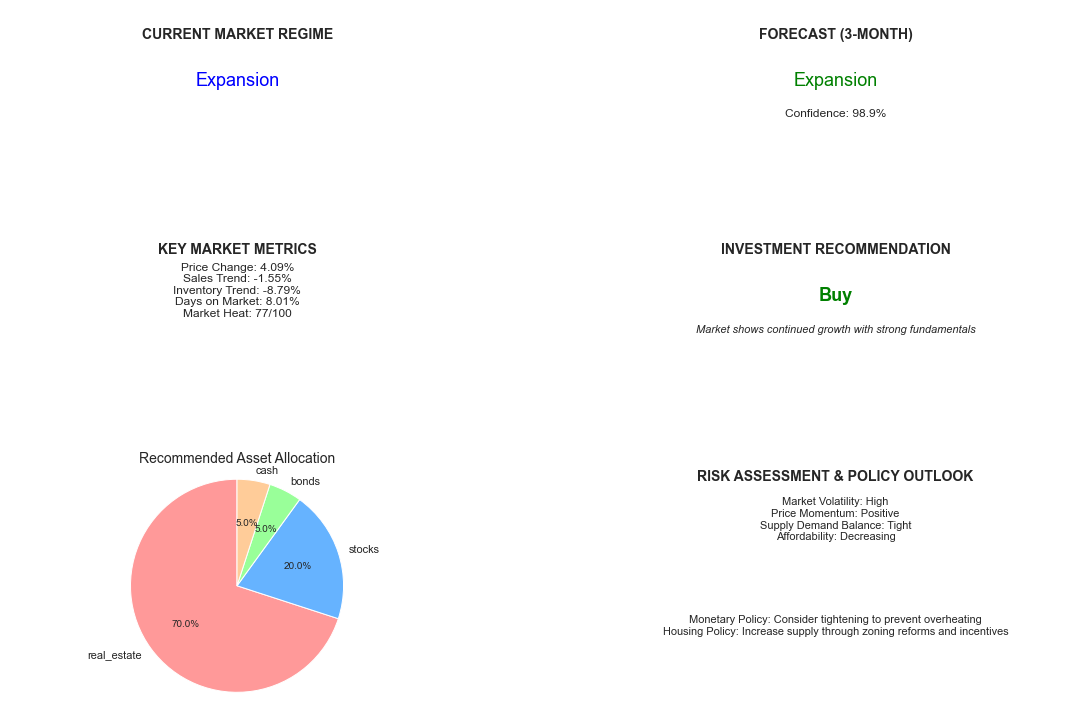

In [15]:
# Create a comprehensive decision support framework
def generate_decision_support(current_regime, forecast_regime, metrics, confidence):
    """
    Generate comprehensive decision support based on market analysis
    
    Parameters:
    -----------
    current_regime : str
        Current market regime
    forecast_regime : str
        Forecasted market regime
    metrics : dict
        Current market metrics
    confidence : float
        Confidence in the forecast (0-1)
        
    Returns:
    --------
    dict
        Decision support recommendations
    """
    # Investment signals
    if current_regime == "Expansion" and forecast_regime == "Expansion":
        investor_signal = {
            "recommendation": "Buy",
            "confidence": confidence,
            "allocation": {"real_estate": 70, "stocks": 20, "bonds": 5, "cash": 5},
            "risk_level": "Moderate",
            "time_horizon": "Medium to Long-term",
            "rationale": "Market shows continued growth with strong fundamentals"
        }
    elif current_regime == "Expansion" and forecast_regime == "Correction":
        investor_signal = {
            "recommendation": "Hold/Reduce",
            "confidence": confidence,
            "allocation": {"real_estate": 40, "stocks": 15, "bonds": 25, "cash": 20},
            "risk_level": "Moderate-High",
            "time_horizon": "Short to Medium-term",
            "rationale": "Signs of market turning, consider profit-taking on overvalued assets"
        }
    elif current_regime == "Correction" and forecast_regime == "Correction":
        investor_signal = {
            "recommendation": "Avoid/Sell",
            "confidence": confidence,
            "allocation": {"real_estate": 20, "stocks": 10, "bonds": 40, "cash": 30},
            "risk_level": "High",
            "time_horizon": "Short-term",
            "rationale": "Continued market weakness expected, protect capital"
        }
    elif current_regime == "Correction" and forecast_regime == "Expansion":
        investor_signal = {
            "recommendation": "Selective Buy",
            "confidence": confidence,
            "allocation": {"real_estate": 50, "stocks": 20, "bonds": 20, "cash": 10},
            "risk_level": "Moderate",
            "time_horizon": "Medium-term",
            "rationale": "Early signs of recovery, opportunity to buy quality assets at discount"
        }
    else:
        investor_signal = {
            "recommendation": "Neutral",
            "confidence": confidence,
            "allocation": {"real_estate": 40, "stocks": 20, "bonds": 30, "cash": 10},
            "risk_level": "Moderate",
            "time_horizon": "Medium-term",
            "rationale": "Mixed signals in the market, maintain diversification"
        }
    
    # Risk metrics
    risk_metrics = {
        "market_volatility": "High" if metrics.get('dom_trend', 0) > 5 else "Moderate",
        "price_momentum": "Positive" if metrics.get('price_change', 0) > 0 else "Negative",
        "supply_demand_balance": "Tight" if metrics.get('inventory_trend', 0) < 0 else "Loosening",
        "affordability": "Decreasing" if metrics.get('price_change', 0) > metrics.get('mortgage', 4) else "Stable"
    }
    
    # Policy recommendations based on regime transitions
    policy_recs = {}
    if current_regime == "Expansion" and forecast_regime in ["Expansion", "Transition"]:
        policy_recs = {
            "monetary_policy": "Consider tightening to prevent overheating",
            "housing_policy": "Increase supply through zoning reforms and incentives",
            "lending_standards": "Tighten to prevent excessive risk-taking",
            "tax_policy": "Consider measures to discourage speculation"
        }
    elif current_regime in ["Correction", "Stagnation"] and forecast_regime in ["Correction", "Stagnation"]:
        policy_recs = {
            "monetary_policy": "Consider easing to support market stability",
            "housing_policy": "Implement support for distressed homeowners",
            "lending_standards": "Maintain prudent standards while supporting liquidity",
            "tax_policy": "Consider temporary relief measures"
        }
    elif current_regime in ["Correction", "Stagnation"] and forecast_regime == "Expansion":
        policy_recs = {
            "monetary_policy": "Begin normalizing gradually as recovery takes hold",
            "housing_policy": "Transition from support to long-term affordability",
            "lending_standards": "Maintain balanced approach to support healthy growth",
            "tax_policy": "Focus on stability and long-term predictability"
        }
    else:
        policy_recs = {
            "monetary_policy": "Maintain balanced approach",
            "housing_policy": "Focus on long-term supply expansion",
            "lending_standards": "Regular monitoring of market conditions",
            "tax_policy": "Stability in tax treatment of real estate"
        }
    
    return {
        "investor_signals": investor_signal,
        "risk_metrics": risk_metrics,
        "policy_recommendations": policy_recs
    }

# Generate current decision support
try:
    if all(var in globals() for var in ['forecast_result', 'global_regime_mapping']):
        # Get current and forecast regimes
        if 'current_regime' in globals():
            current_reg = current_regime
        else:
            # Use the most recent regime from history
            current_reg = regime_history['regime'].iloc[-1]
            
        forecast_reg = forecast_result['predicted_regime']
        confidence = forecast_result['probabilities'][forecast_reg]
        
        # Get current metrics
        if 'current_metrics' in globals():
            metrics = current_metrics
        else:
            # Create default metrics from recent data
            recent_data = df_processed.iloc[-3:]
            metrics = {
                'price_change': recent_data['YOY_CHANGE'].mean(),
                'price_trend': recent_data['ZHVI'].pct_change().mean() * 100,
                'inventory_trend': recent_data['INVENTORY'].pct_change().mean() * 100,
                'sales_trend': recent_data['SALES_VOLUME'].pct_change().mean() * 100,
                'dom_trend': recent_data['DOM'].pct_change().mean() * 100,
                'mortgage': recent_data['MORTGAGE'].mean(),
                'market_heat': recent_data['MARKET_HEAT_INDEX'].mean() if 'MARKET_HEAT_INDEX' in recent_data.columns else 50
            }
        
        decision_support = generate_decision_support(
            current_reg, 
            forecast_reg, 
            metrics,
            confidence
        )
        
        # Create a visual dashboard for decision support
        plt.figure(figsize=(15, 10))
        
        # Set up the grid
        gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 1.5])
        
        # Current regime indicator
        ax1 = plt.subplot(gs[0, 0])
        ax1.axis('off')
        ax1.text(0.5, 0.8, 'CURRENT MARKET REGIME', fontsize=14, ha='center', weight='bold')
        ax1.text(0.5, 0.5, current_reg, fontsize=18, ha='center', color='blue')
        
        # Forecast indicator
        ax2 = plt.subplot(gs[0, 1])
        ax2.axis('off')
        ax2.text(0.5, 0.8, 'FORECAST (3-MONTH)', fontsize=14, ha='center', weight='bold')
        ax2.text(0.5, 0.5, forecast_reg, fontsize=18, ha='center', 
                color='green' if forecast_reg == 'Expansion' else 'red' if forecast_reg == 'Correction' else 'orange')
        ax2.text(0.5, 0.3, f"Confidence: {confidence*100:.1f}%", fontsize=12, ha='center')
        
        # Key metrics
        ax3 = plt.subplot(gs[1, 0])
        ax3.axis('off')
        ax3.text(0.5, 0.9, 'KEY MARKET METRICS', fontsize=14, ha='center', weight='bold')
        metrics_text = '\n'.join([
            f"Price Change: {metrics['price_change']:.2f}%",
            f"Sales Trend: {metrics['sales_trend']:.2f}%",
            f"Inventory Trend: {metrics['inventory_trend']:.2f}%",
            f"Days on Market: {metrics['dom_trend']:.2f}%",
            f"Market Heat: {metrics['market_heat']:.0f}/100"
        ])
        ax3.text(0.5, 0.5, metrics_text, fontsize=12, ha='center')
        
        # Investment recommendation
        ax4 = plt.subplot(gs[1, 1])
        ax4.axis('off')
        ax4.text(0.5, 0.9, 'INVESTMENT RECOMMENDATION', fontsize=14, ha='center', weight='bold')
        ax4.text(0.5, 0.6, decision_support['investor_signals']['recommendation'], 
                fontsize=18, ha='center', weight='bold',
                color='green' if 'Buy' in decision_support['investor_signals']['recommendation'] else 
                      'red' if 'Sell' in decision_support['investor_signals']['recommendation'] else 'blue')
        ax4.text(0.5, 0.4, decision_support['investor_signals']['rationale'], 
                fontsize=11, ha='center', style='italic')
        
        # Asset allocation
        ax5 = plt.subplot(gs[2, 0])
        allocation = decision_support['investor_signals']['allocation']
        labels = allocation.keys()
        sizes = allocation.values()
        ax5.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
               colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
        ax5.axis('equal')
        ax5.set_title('Recommended Asset Allocation', fontsize=14)
        
        # Risk metrics and policy recommendations
        ax6 = plt.subplot(gs[2, 1])
        ax6.axis('off')
        ax6.text(0.5, 0.95, 'RISK ASSESSMENT & POLICY OUTLOOK', fontsize=14, ha='center', weight='bold')
        
        risk_text = '\n'.join([f"{k.replace('_', ' ').title()}: {v}" for k, v in decision_support['risk_metrics'].items()])
        ax6.text(0.5, 0.7, risk_text, fontsize=11, ha='center')
        
        policy_text = '\n'.join([f"{k.replace('_', ' ').title()}: {v}" 
                                 for k, v in list(decision_support['policy_recommendations'].items())[:2]])
        ax6.text(0.5, 0.3, policy_text, fontsize=11, ha='center')
        
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.show()
        
    else:
        print("Forecast results not available. Please run the forecast cell first.")
        missing_vars = [var for var in ['forecast_result', 'global_regime_mapping'] 
                        if var not in globals()]
        if missing_vars:
            print(f"Missing variables: {missing_vars}")
        
except Exception as e:
    print(f"Error generating decision support: {e}")
    import traceback
    traceback.print_exc()
    print("Continue with partial analysis using available data.")